In [ ]:
# https://pypi.org/project/audioread/

import librosa
import librosa.display
import librosa.util
import librosa.filters
import librosa.display
from librosa.core import audio

import soundfile as sf

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from pydub import AudioSegment

import scipy
from scipy.io.wavfile import write
from scipy import signal
from scipy.signal import butter, lfilter



In [ ]:
def load_file(filename):
    return librosa.load(glob(filename)[0])



In [ ]:
def calculate_rms(samples):
    """Given a numpy array of audio samples, return its Root Mean Square (RMS)."""
    return np.sqrt(np.mean(np.square(samples)))

def calculate_desired_noise_rms(clean_rms, snr):
    """
    Given the Root Mean Square (RMS) of a clean sound and a desired signal-to-noise ratio (SNR),
    calculate the desired RMS of a noise sound to be mixed in.
    Based on https://github.com/Sato-Kunihiko/audio-SNR/blob/8d2c933b6c0afe6f1203251f4877e7a1068a6130/create_mixed_audio_file.py#L20
    :param clean_rms: Root Mean Square (RMS) - a value between 0.0 and 1.0
    :param snr: Signal-to-Noise (SNR) Ratio in dB - typically somewhere between -20 and 60
    :return:
    """
    a = float(snr) / 20
    noise_rms = clean_rms / (10**a)
    return noise_rms



In [ ]:
def convert_decibels_to_amplitude_ratio(decibels):
    return 10 ** (decibels / 20)

def set_noise(y, noise_rms):
    #amp = convert_decibels_to_amplitude_ratio(decibels)
    #y = np.random.rand(y.shape[0])*amp*2-amp
    noise = np.random.normal(
            0.0, noise_rms, size=y.shape
        )
    return noise


In [ ]:
  
def splice_out(filename, outputfile, type, time_ranges, snr=10):
    y, fs = load_file(filename)

    # Convert time_ranges from seconds to samples
    ranges = [(int(start * fs), int(end * fs)) for start, end in time_ranges]

    if type == 1:
        for start, end in ranges:
            y = np.delete(y, np.s_[start:end])
    elif type == 2:
        for start, end in ranges:
            y[start:end] = 0
    elif type == 3:
        rms = calculate_rms(y)
        noise_rms = calculate_desired_noise_rms(rms, snr)
        for start, end in ranges:
            y[start:end] = set_noise(y[start:end], noise_rms)
    else:
        print("Invalid type input")

    
    pd.Series(y).plot(figsize=(10, 5), lw=1, title=str(type))
    
    sf.write(outputfile, y, fs)

splice_out("../testfiles/upc_ca_ona_100000.wav","../resources/upc_ca_ona_100000SPLICE2.wav",2,[(6, 7),(7.5 , 7.7),(10, 11)])

#y = np.delete(y, np.s_[40000:45000])
#print(y.shape)



In [ ]:
time = pd.Series(range(len(y))) / sr
plt.figure(figsize=(10, 6))
plt.plot(time, y)
plt.title('Original Signal')
plt.tight_layout()
plt.show()

In [ ]:
sf.write('out.wav', y, sr, 'PCM_24')
os.system("rm out.mp3")
os.system("ffmpeg -i out.wav out.mp3")


In [ ]:
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

In [ ]:
plt.figure()
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Now with labeled axes!')
fig.colorbar(img, ax=ax, format="%+2.f dB")



ffmpeg -i input.wav -codec:a libmp3lame -qscale:a 2 output.mp3

Control quality with -qscale:a (or the alias -q:a). Values are encoder specific, so for libmp3lame the range is 0-9 where a lower value is a higher quality. 0-3 will normally produce transparent results, 4 (default) should be close to perceptual transparency, and 6 produces an "acceptable" quality. The option -qscale:a is mapped to the -V option in the standalone lame command-line interface tool.

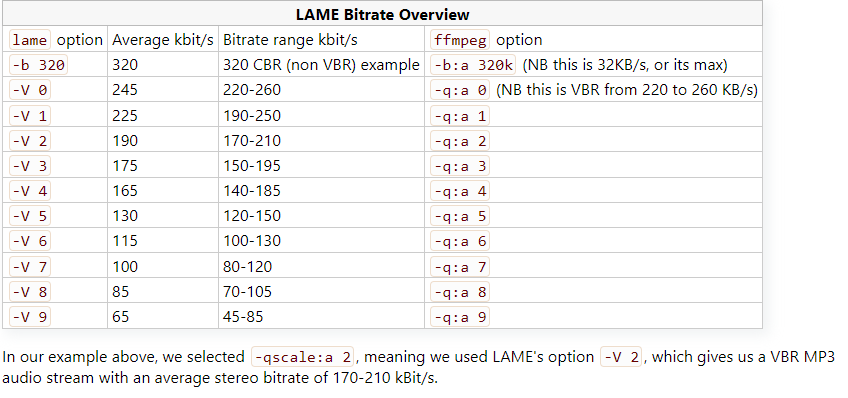

In [ ]:
#test mp3compression
#0->best
#4->perceptual transparency
#6->acceptable
#8->bad
def mp3compression(inputfile,quality=4):
    outputfile=inputfile.split('.')[0]+"_"+str(quality)+".mp3"
    os.system("ffmpeg -y -i " + inputfile +" -codec:a libmp3lame -q:a " + str(quality) + " " +outputfile)

mp3compression("out.mp3",6)


#clipping
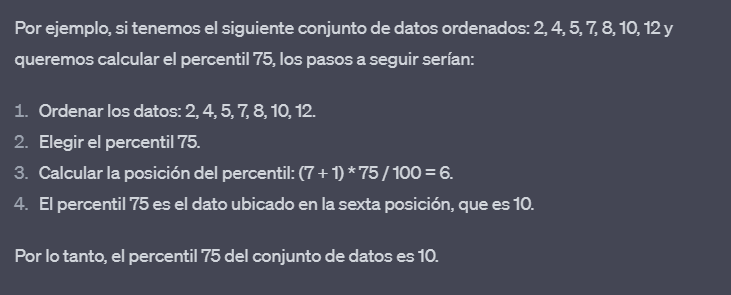

In [ ]:
#clipping
def clipping(filename,outputfile,percentile_threshold=10.0):
    samples, fs = load_file(filename)
    lower_percentile_threshold = percentile_threshold/2
    print(lower_percentile_threshold)
    lower_threshold, upper_threshold = np.percentile(
            samples, [lower_percentile_threshold, 100 - lower_percentile_threshold])
    print(lower_threshold)
    print(upper_threshold)
    samples = np.clip(samples, lower_threshold, upper_threshold)
    pd.Series(samples).plot(figsize=(10, 5), lw=1, title="")
    librosa.output.write_wav(outputfile, samples, fs)
    
samples, sr = load_file("../test.mp3")


In [ ]:

pd.Series(samples).plot(figsize=(10, 5), lw=1, title="")


In [ ]:

clipping("../test.mp3",0)


In [ ]:

#7 band equalizer
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    filtered = lfilter(b, a, data)
    return filtered

def equalizer (filename, outputfile , gain1=0, gain2=0, gain3=0, gain4=0, gain5=0, gain6=0, gain7=0, gain8=0, gain9=0, gain10=0):
    data, fs = load_file(filename)
    band1 = bandpass_filter(data, 20, 95, fs, order=2)* 10**(gain1/20)
    band2 = bandpass_filter(data, 91, 204, fs, order=3)*10**(gain2/20)
    band3 = bandpass_filter(data, 196, 441, fs, order=3)*10**(gain3/20)
    band4 = bandpass_filter(data, 421, 948, fs, order=3)* 10**(gain4/20)
    band5 = bandpass_filter(data, 909, 2045, fs, order=3)* 10**(gain5/20)
    band6 = bandpass_filter(data, 1957, 4404, fs, order=3)* 10**(gain6/20)
    band7 = bandpass_filter(data, 4216, 9486, fs, order=3)* 10**(gain7/20)
    
    signal = band1 + band2 + band3 + band4 + band5 + band6 + band7 

    # Save output audio to file
    librosa.output.write_wav(outputfile, signal, fs)
    
    


In [ ]:


data, sr = load_file("../test.mp3")

N = len(data)
t  = 1/sr * np.arange(N) 
f  = sr/N * np.arange(N)
#computing fft of original signal
F_data = np.fft.fft(data)/N

#appying equalizer
equalizer("../test.mp3", "output.wav" ,  0,0,-100,-100,-100,0,0)
equalized, sr = load_file("../test.mp3")

#computing fft of filtered signal
Y = np.fft.fft(equalized)/N

plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
plt.plot(t, data,'-r',label=r"$Original amplitude(t)$")
plt.xlabel('time[s]')

plt.subplot(2,1,1)
plt.plot(t, equalized,'-b',label=r"$Filtered amplitude(t)$")
plt.xlabel('time[s]')

plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(f[:N//2],np.abs(F_data[:N//2]),'-r',label=r"$Original magnitude(f)$")
plt.xlabel('f [Hz]')
plt.xlim([0,5e3])
plt.plot(f[:N//2],np.abs(Y[:N//2]),'-b',label=r"$Filtered magnitude(f)$")
plt.xlabel('f [Hz]')
plt.xlim([0,5e3])
plt.legend()
plt.tight_layout()
plt.grid()

In [ ]:



#vltp
#apply_vtlp function that identifies the formants of the input audio signal and applies the VTLP transform using those formants:

#import sounddevice as sd

def apply_vtlp1(signal, vtlp_factor):
    # Calculate the mel spectrogram of the input signal
    mel_spec = librosa.feature.melspectrogram(signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)

    # Convert the mel spectrogram to dB units
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    print(mel_spec)
    # Find the peaks in the mel spectrogram
    peak_frequencies = librosa.util.peak_pick(mel_spec_db, 3, 3, 3, 5, 0.5, 10)

    # Sort the peaks by frequency
    sorted_peaks = np.sort(peak_frequencies)

    # Calculate the new formant frequencies based on the VTL factor and the sorted peaks
    new_formants = sorted_peaks * vtlp_factor

    # Calculate the bandwidths of the formants
    bw = new_formants / 2.0

    # Define the center frequencies and bandwidths of the formants
    formants = np.stack((new_formants, bw), axis=1)

    # Apply a bandpass filter to the signal at the frequencies of the formants
    filtered_signal = np.zeros_like(signal)
    for i in range(formants.shape[0]):
        center_freq = formants[i][0]
        bandwidth = formants[i][1]
        b, a = librosa.core.audio.util.band_pass(center_freq - bandwidth, center_freq + bandwidth, signal.fs)
        filtered_signal += librosa.core.audio.util.pad_center(librosa.core.audio.util.filtfilt(b, a, signal), len(signal))

    return filtered_signal


def vtlp1(signal, sr, vtl_factor):
    # Step 1: Compute the Mel filterbank coefficients
    mel_filterbank = librosa.filters.mel(sr, n_fft=2048, n_mels=20)

    # Step 2: Apply the VTL perturbation
    vtl_filterbank = vtl_factor * mel_filterbank + (1 - vtl_factor) * np.roll(mel_filterbank, 1, axis=0)

    # Step 3: Convert the signal to the Mel frequency scale
    vtl_mel_spec = np.dot(vtl_filterbank, librosa.stft(signal))

    # Step 4: Convert the signal back to the time domain
    vtl_signal = librosa.istft(vtl_mel_spec, hop_length=512)

    return vtl_signal

# https://pypi.org/project/audioread/

# Load an audio file
y, sr = load_file("../test.mp3")
y_vtl = vtlp(y,sr,1)

# Create time axis
time = pd.Series(range(len(y))) / sr
time1 = pd.Series(range(len(y_vtl))) / sr

# Plot the original and perturbed signals
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time, y)
plt.title('Original Signal')
plt.subplot(2, 1, 2)
plt.plot(time1, y_vtl)
plt.title('Perturbed Signal ')
plt.tight_layout()
plt.show()
# Define the VTL factor
#vtlp_factor = 1.2

# Apply the VTL factor to the signal
#vtlp_signal = apply_vtlp(y, vtlp_factor)

# Play the original signal
#sd.play(y, sr)
#sd.wait()

# Play the signal with the VTL factor applied
#sd.play(vtlp_signal, sr)
#sd.wait()





# Play the signal with the VTL factor applied
sf.write('vtlp_test.wav', y_vtl, sr, 'PCM_24')
#This function takes as input an audio signal and a VTLP factor. It first calculates the mel spectrogram of the input signal using librosa.feature.melspectrogram, and then identifies the three highest peaks in the mel spectrogram using librosa.core.peak_pick.
#The function then sorts the peak frequencies by frequency, and calculates the new formant frequencies based on the VTLP factor and the sorted peaks. The bandwidths of the formants are calculated as half of the new formant frequencies.
#Finally, the function applies a bandpass filter to the signal at the frequencies of the formants using librosa.core.audio.util.band_pass, and returns the filtered signal.
#Note that this is just a simple example implementation of formant-based VTLP, and there are many other techniques and parameters that can be used depending on the specific application.


In [ ]:
def vtlp_filters(fbank_mx, alpha=1.0, f_high=None):
    """
    Apply vocal tract length perturbation (VTLP) to the filterbank matrix.
    :param fbank_mx: filterbank matrix
    :param alpha: warping factor
    :param f_high: maximum frequency for warping
    :return: warped filterbank matrix
    """
    n_filters, n_fft = fbank_mx.shape
    warped_filters = np.zeros((n_filters, n_fft))
    
    if f_high is None:
        f_high = n_fft / 2
    
    for m in range(n_filters):
        for k in range(n_fft):
            f = (n_fft - 1) * k / (n_fft - 1)
            if f < f_high / 2:
                f_warped = alpha * f
            elif f < f_high:
                f_warped = alpha * f + (1 - alpha) * (f_high / 2)
            else:
                f_warped = f
            
            k_warped = int(n_fft * f_warped / (n_fft - 1))
            if k_warped < n_fft:
                warped_filters[m, k_warped] += fbank_mx[m, k]
    
    return warped_filters



def vtlp(input_wav_file, output_wav_file, alpha=1.0, f_high=None):
    """
    Apply vocal tract length perturbation (VTLP) to a .wav file.
    :param input_wav_file: input .wav file
    :param output_wav_file: output .wav file
    :param alpha: warping factor
    :param f_high: maximum frequency for warping
    """
    # Load the input .wav file
    y, sr = librosa.load(input_wav_file)
    
    # Compute the spectrogram
    n_fft = 2048
    hop_length = 512
    win_length = n_fft
    window = scipy.signal.windows.hann(win_length, sym=False)
    
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    
    # Compute the filterbank matrix
    n_mels = 256
    fbank_mx = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    
    # Apply VTLP to the filterbank matrix
    warped_filters = vtlp_filters(fbank_mx, alpha=alpha, f_high=f_high)
    
    # Compute the mel spectrogram using the warped filterbank matrix
    S = np.dot(warped_filters, np.abs(D))
    
    # Invert the mel spectrogram to audio
    y_hat = librosa.feature.inverse.mel_to_audio(S,
                                                 sr=sr,
                                                 n_fft=n_fft,
                                                 hop_length=hop_length,
                                                 win_length=win_length,
                                                 window=window,
                                                 power=1,
                                                 n_iter=128,
                                                 length=len(y))
    
    time = pd.Series(range(len(y))) / sr
    time1 = pd.Series(range(len(y_hat))) / sr

    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, y)
    plt.title('Original Signal')
    plt.subplot(2, 1, 2)
    plt.plot(time1, y_hat)
    plt.title('Perturbed Signal ')
    plt.tight_layout()
    plt.show()

    # Save the output .wav file
    write(output_wav_file, sr, y_hat)


vtlp("../test.mp3","vtlpout.wav", 1)



In [ ]:
from functions import *
visualize_signals("../test.mp3","tout.wav")


In [ ]:

y, fs1 = load_file("../test.mp3")
y_tr, fs2 = load_file("vtlpout.wav")

time = pd.Series(range(len(y))) / fs1
time1 = pd.Series(range(len(y_tr))) / fs2

D = librosa.stft(y)  # STFT of y
D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

S = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

fig, axs = plt.subplots(2,2)


fig.colorbar(img, ax=ax, format="%+2.f dB")

fig, axs = plt.subplots(2,2)

plt.figure(figsize=(10, 8))

axs[0, 0].set_title('Original signal')
img = librosa.display.waveshow(y, sr=fs1, color='r')
fig
#plt.plot(time, y, '-r', label=r"$Original (t)$")


# plt.grid()

# plt.subplot(2, 1, 2)
# librosa.display.waveshow(y_tr, sr=fs2, color='b')
# plt.title('Transformed Signal ')
# plt.grid()

# plt.subplot(2, 2, 1)
# librosa.display.specshow(D_db, x_axis='time', y_axis='log', ax=ax)
# plt.title('Original Signal stft')


# plt.subplot(2, 2, 1)
# librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax)
# plt.title('Transformed Signal stft')


# plt.tight_layout()
# plt.grid()



In [ ]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal

def plot_waveform_and_stft(original_file, transformed_file):
    # Read in the original audio file
    sample_rate1, samples1 = wavfile.read(original_file)
    # Plot the waveform of the original audio file
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 2, 1)
    plt.title('Original Waveform')
    plt.plot(samples1)
    
    # Compute and plot the STFT of the original audio file
    f1, t1, Zxx1 = signal.stft(samples1, sample_rate1)
    plt.subplot(2, 2, 2)
    plt.title('Original STFT')
    plt.pcolormesh(t1, f1, np.abs(Zxx1), shading='gouraud')
    
    # Read in the transformed audio file
    sample_rate2, samples2 = wavfile.read(transformed_file)
    # Plot the waveform of the transformed audio file
    plt.subplot(2, 2, 3)
    plt.title('Transformed Waveform')
    plt.plot(samples2)
    
    # Compute and plot the STFT of the transformed audio file
    f2, t2, Zxx2 = signal.stft(samples2, sample_rate2)
    plt.subplot(2, 2, 4)
    plt.title('Transformed STFT')
    plt.pcolormesh(t2, f2, np.abs(Zxx2), shading='gouraud')
    
    # Show the plots
    plt.tight_layout()
    plt.show()

plot_waveform_and_stft("vtlp_test.wav","vtlpout.wav")



In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot_waveform_and_stft_librosa(original_file, transformed_file):
    # Load the original audio file
    y1, sr1 = librosa.load(original_file)
    # Plot the waveform of the original audio file
    plt.figure(figsize=(10, 6))
       
    # Load the transformed audio file
    y2, sr2 = librosa.load(original_file)
    # Plot the waveform of the transformed audio file
    plt.subplot(2, 1, 1)
    plt.title('Waveform upc_ca_ona_100000SPLICE3.wav')
    librosa.display.waveshow(y2, sr=sr2)
    
    # Compute and plot the STFT of the transformed audio file
    D2 = librosa.stft(y2)
    plt.subplot(2, 1, 2)
    plt.title('STFT upc_ca_ona_100000SPLICE3.wav')
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D2), ref=np.max), y_axis='log', x_axis='time', cmap='viridis', shading='gouraud')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    
    # Show the plots
    plt.tight_layout()
    plt.show()

plot_waveform_and_stft_librosa("../resources/upc_ca_ona_100000SPLICE3.wav","tout.wav")


#plot_waveform_and_stft_librosa("../resources/upc_ca_ona_100000SPLICE.wav","../resources/upc_ca_ona_100000SPLICE.wav")
#plot_waveform_and_stft_librosa("../resources/upc_ca_ona_100000SPLICE.wav","../resources/upc_ca_ona_100000mp3.wav")
#plot_waveform_and_stft_librosa("../resources/upc_ca_ona_100000SPLICE.wav","../resources/upc_ca_ona_100000vtlp.wav")
#plot_waveform_and_stft_librosa("../resources/upc_ca_ona_100000SPLICE.wav","../resources/upc_ca_ona_100000EQ.wav")
#plot_waveform_and_stft_librosa("../resources/upc_ca_ona_100000SPLICE.wav","../resources/upc_ca_ona_100000Clipping.wav")


In [ ]:
from functions import *
splice_out("../testfiles/upc_ca_ona_100000.wav","../resources/upc_ca_ona_100000SPLICE2.wav",2,[(6, 6.2),(7.5 , 7.7),(10, 10.2)])
mp3compression("../testfiles/upc_ca_ona_100000.wav","../resources/upc_ca_ona_100000mp3.wav", 8)
vtlp("../testfiles/upc_ca_ona_100000.wav","../resources/upc_ca_ona_100000vtlp.wav",1.2)
equalizer("../testfiles/upc_ca_ona_100000.wav","../resources/upc_ca_ona_100000EQ.wav",-15,-15,-15,-15,-15,-15,-15)
clipping("../testfiles/upc_ca_ona_100000.wav","../resources/upc_ca_ona_100000Clipping.wav",5)



In [ ]:
from functions import *

clipping("../testfiles/UPC_CA_ONA_WAV/upc_ca_ona_100000.wav","../testfiles/UPC_CA_ONA_WAV/upc_ca_ona_100000c40.wav",40)





In [ ]:

import librosa
import numpy as np
import soundfile as sf
from PESQ import *

def add_white_noise(input_filename, output_filename, desired_db):
    # Read the input audio file
    signal, sr = librosa.load(input_filename,sr=None)
    print(sr)
    # Generate white noise
    noise = np.random.normal(0, 1, signal.shape)
    
    # Calculate the scaling factor for the desired dB level
    max_signal = np.max(np.abs(signal))
    max_noise = 10**(desired_db / 10) * max_signal
    noise = (noise / np.max(np.abs(noise))) * max_noise
    
    # Add the scaled white noise to the original signal
    noisy_signal = signal + noise
    
    # Save the modified audio signal to the output file
    sf.write(output_filename, noisy_signal, sr)


# Example usage
input_filename = "upc_ca_ona_100000.wav"
output_filename = "upc_ca_ona_100000db40.wav"
desired_db = 40
#add_white_noise(input_filename, output_filename, desired_db)



score = pesq_from_paths(input_filename, output_filename)

print(str(score).replace("tensor(", "").replace(")", ""))

In [2]:
import librosa
import numpy as np
import soundfile as sf
from PESQ import *

def add_white_noise(input_filename, output_filename, desired_snr):
    # Read the input audio file
    signal, sr = librosa.load(input_filename, sr=None)

    # Generate white noise
    noise = np.random.normal(0, 1, signal.shape)

    # Calculate the signal and noise power
    signal_power = np.sum(signal ** 2) / signal.size
    noise_power = np.sum(noise ** 2) / noise.size

    # Calculate the scaling factor for the desired SNR level
    scaling_factor = np.sqrt((signal_power / noise_power) * 10 ** (-desired_snr / 20))

    # Scale the noise
    noise_scaled = noise * scaling_factor

    # Add the scaled white noise to the original signal
    noisy_signal = signal + noise_scaled

    # Save the modified audio signal to the output file
    sf.write(output_filename, noisy_signal, sr)

# Example usage
input_filename = "upc_ca_ona_100000.wav"
output_filename = "upc_ca_ona_100000snr20.wav"
desired_snr = 20
add_white_noise(input_filename, output_filename, desired_snr)

score = pesq_from_paths(input_filename, output_filename)

print(str(score).replace("tensor(", "").replace(")", ""))


1.1404


In [12]:
import librosa
import numpy as np
import soundfile as sf
from PESQ import *

def add_white_noise(input_filename, output_filename, desired_snr):
    # Read the input audio file
    signal, sr = librosa.load(input_filename, sr=None)

    # Remove silence from the start and end of the signal
    trimmed_signal, _ = librosa.effects.trim(signal)

    # Generate white noise
    noise = np.random.normal(0, 1, trimmed_signal.shape)

    # Calculate the signal and noise power
    signal_power = np.sum(trimmed_signal ** 2) / trimmed_signal.size
    noise_power = np.sum(noise ** 2) / noise.size

    # Calculate the scaling factor for the desired SNR level
    scaling_factor = np.sqrt((signal_power / noise_power) * 10 ** (-desired_snr / 10))

    # Scale the noise
    noise_scaled = noise * scaling_factor

    # Add the scaled white noise to the trimmed signal
    noisy_signal = trimmed_signal + noise_scaled

    # Save the modified audio signal to the output file
    sf.write(output_filename, noisy_signal, sr)

# Example usage
input_filename = "upc_ca_ona_100000.wav"
output_filename = "upc_ca_ona_100000snr20.wav"
desired_snr = 20
add_white_noise(input_filename, output_filename, desired_snr)

score = pesq_from_paths(input_filename, output_filename)

print(str(score).replace("tensor(", "").replace(")", ""))


1.7428


In [ ]:
import os
import glob
import librosa
import numpy as np
import soundfile as sf
def add_white_noise(input_filename, output_filename, desired_snr):
    # Read the input audio file
    signal, sr = librosa.load(input_filename, sr=None)

    # Remove silence from the start and end of the signal
    trimmed_signal, _ = librosa.effects.trim(signal)

    # Generate white noise
    noise = np.random.normal(0, 1, trimmed_signal.shape)

    # Calculate the signal and noise power
    signal_power = np.sum(trimmed_signal ** 2) / trimmed_signal.size
    noise_power = np.sum(noise ** 2) / noise.size

    # Calculate the scaling factor for the desired SNR level
    scaling_factor = np.sqrt((signal_power / noise_power) * 10 ** (-desired_snr / 10))

    # Scale the noise
    noise_scaled = noise * scaling_factor

    # Add the scaled white noise to the trimmed signal
    noisy_signal = trimmed_signal + noise_scaled

    # Save the modified audio signal to the output file
    sf.write(output_filename, noisy_signal, sr)

input_folder = 'input_folder'
output_folder = 'output_folder'
snr_values = [-10, 0, 10, 20, 30, 40]

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for desired_snr in snr_values:
    output_folder = os.path.join(output_folder, f'SNR{desired_snr}')
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    output_folder = os.path.join(output_folder, f'SNR{desired_snr}')

    for file in glob.glob(os.path.join(input_folder, '*.wav')):
        output_filename = os.path.join(output_folder, os.path.basename(file))
        add_white_noise(file, output_filename, desired_snr)

